In [1]:
!git clone https://github.com/KHiMAeRA05/PMLDL_Text_Detoxification.git
!pip install evaluate rouge_score sentence_transformers

Cloning into 'PMLDL_Text_Detoxification'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 40 (delta 5), reused 24 (delta 2), pack-reused 0
Receiving objects: 100% (40/40), 9.25 KiB | 2.31 MiB/s, done.
Resolving deltas: 100% (5/5), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5dd78d8c8430b385f7027eebfe42727f61f60526d34d781dbb04e60cb7f6f467
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=b0d4dae28b53b52734241eda76d1116237eb

In [3]:
import nltk
from datasets import Dataset
import evaluate
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

# Prepare and tokenize dataset
df = pd.read_csv('/kaggle/working/PMLDL_Text_Detoxification/data/raw/filtered.tsv', sep='\t')
df = df.drop(columns=['Unnamed: 0'])
mask = df['trn_tox'] > df['ref_tox']
# Swap the values of reference and translation, and ref_tox and trn_tox where the condition is True
df.loc[mask, ['reference', 'translation', 'ref_tox', 'trn_tox']] = df.loc[mask, ['translation', 'reference', 'trn_tox', 'ref_tox']].values


dataset = Dataset.from_pandas(df).shuffle(seed=42)#.select(range(20000))
dataset = dataset.train_test_split(test_size=0.2)
tokenizer = AutoTokenizer.from_pretrained("t5-small")
prefix = "paraphrase: "

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["reference"]]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True)

    labels = tokenizer(text_target=examples["translation"], max_length=256, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Setup evaluation
nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # decode preds and labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

# Load pretrained model and evaluate model after each epoch
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    fp16=True,
    predict_with_generate=True,
    report_to='none'
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/463 [00:00<?, ?ba/s]

  0%|          | 0/116 [00:00<?, ?ba/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.971400,1.806572,0.571442,0.336363,0.553529,0.553812


TrainOutput(global_step=28889, training_loss=2.0355960965185442, metrics={'train_runtime': 9226.5435, 'train_samples_per_second': 50.097, 'train_steps_per_second': 3.131, 'total_flos': 5292806279036928.0, 'train_loss': 2.0355960965185442, 'epoch': 1.0})

In [4]:
trainer.evaluate()

KeyboardInterrupt: 

In [10]:
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

class ToxicityPredictor:
    def __init__(self, model_name='SkolkovoInstitute/roberta_toxicity_classifier'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.classifier = pipeline("text-classification", model=self.model, tokenizer=self.tokenizer)

    def predict(self, text):
        result = self.classifier(text)
        score = result[0]['score']
        if result[0]['label'] == 'neutral':
            score = 1 - score
        return score

# Usage example:
# predictor = ToxicityPredictor("facebook/roberta-hate-speech-dynabench-r4-target")
# prediction = predictor.predict("This is an example sentence.")
# print(prediction)

In [11]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics.pairwise import cosine_similarity

class TextSimilarityModel:
    def __init__(self, model_name='distilbert-base-uncased'):
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.model = DistilBertModel.from_pretrained(model_name)

    def calculate_similarity(self, text1, text2):
        input_ids1 = self.tokenizer(text1, return_tensors='pt').input_ids
        input_ids2 = self.tokenizer(text2, return_tensors='pt').input_ids
        with torch.no_grad():
            emb1 = self.model(input_ids1).last_hidden_state[:, 0, :]
            emb2 = self.model(input_ids2).last_hidden_state[:, 0, :]
        return cosine_similarity(emb1, emb2)

    def predict(self, text1, text2):
        similarity_score = self.calculate_similarity(text1, text2)[0][0]
        return similarity_score

# Example usage

# # Create an instance of the TextSimilarityModel
# similarity_model = TextSimilarityModel()

In [12]:
toxic_url = "https://raw.githubusercontent.com/surge-ai/toxicity/main/toxicity_en.csv"
df_toxicity = pd.read_csv(toxic_url)
df_toxicity = df_toxicity[df_toxicity['is_toxic'] == 'Toxic']
df_toxicity

,text,is_toxic
0,"Elon Musk is a piece of shit, greedy capitalis...",Toxic
1,The senile credit card shrill from Delaware ne...,Toxic
2,He does that a lot -- makes everyone look good...,Toxic
3,F*ck Lizzo,Toxic
4,Epstein and trump were best buds!!! Pedophiles...,Toxic
...,...,...
496,By now the Americans knew that the roots cause...,Toxic
497,For fentanyl floyed,Toxic
498,Attack only Chinese not other Asians,Toxic
499,ILLEGALS ARE COMING FROM THE NORTH DUMBASS DO ...,Toxic


In [13]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
from tqdm import tqdm_notebook

simularity_model = TextSimilarityModel()
toxicity_model = ToxicityPredictor()

# Define a function to calculate similarity
def calculate_similarity(sentence1, sentence2):
    #print(sentence1, sentence2)
    return simularity_model.predict(text1=sentence1, text2=sentence2)

# Define a function to assess toxicity (if you have a toxicity classifier)
def assess_toxicity(sentence):
    return toxicity_model.predict(sentence)

# Generate paraphrases and calculate similarity
generated_paraphrases = []
texts=df_toxicity['text'].to_list()
encoded_texts = tokenizer(texts, return_tensors="pt", padding=True)
encoded_texts = {k: v.to(trainer.model.device) for k,v in encoded_texts.items()}
outputs = trainer.model.generate(encoded_texts["input_ids"])

for output, sentence in tqdm_notebook(zip(outputs, texts), total=len(texts)):
    paraphrase = tokenizer.decode(output, skip_special_tokens=True)
    similarity = calculate_similarity(sentence, paraphrase)
    original_toxicity_score = assess_toxicity(sentence)
    generated_toxicity_score = assess_toxicity(paraphrase)
    generated_paraphrases.append({
        'Original Sentence': sentence,
        'Generated Paraphrase': paraphrase,
        'Similarity (meaning)': similarity,
        'Original Toxicity Score': original_toxicity_score,
        'Generated Toxicity Score': generated_toxicity_score
    })

# Create a DataFrame
df_generated_paraphrases = pd.DataFrame(generated_paraphrases)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/tmp/ip

  0%|          | 0/501 [00:00<?, ?it/s]

In [14]:
# Display the DataFrame
df_generated_paraphrases

,Original Sentence,Generated Paraphrase,Similarity (meaning),Original Toxicity Score,Generated Toxicity Score
0,"Elon Musk is a piece of shit, greedy capitalis...","Elon Musk is a shit, greedy capitalist who exp...",0.949480,0.997041,0.999422
1,The senile credit card shrill from Delaware ne...,The senile credit card shrill from Delaware ne...,0.994585,0.163491,0.126859
2,He does that a lot -- makes everyone look good...,"He does it a lot, makes everyone look good, bu...",0.961818,0.998675,0.000074
3,F*ck Lizzo,"F*ck Lizzo, F*ck Lizzo.",0.966184,0.998519,0.998322
4,Epstein and trump were best buds!!! Pedophiles...,"Epstein and trump were the best buds, Pedophil...",0.955901,0.984035,0.019969
...,...,...,...,...,...
496,By now the Americans knew that the roots cause...,"By now, the Americans knew that the root cause...",0.937863,0.203886,0.000251
497,For fentanyl floyed,"For fentanyl floyed, fentanyl floyed.",0.952122,0.000063,0.000048
498,Attack only Chinese not other Asians,"Attack only Chinese, not Asians.",0.941199,0.994895,0.997094
499,ILLEGALS ARE COMING FROM THE NORTH DUMBASS DO ...,ILLEGALS ARE COMING FROM THE NORTH DUMBASS DO,0.946543,0.999206,0.781724


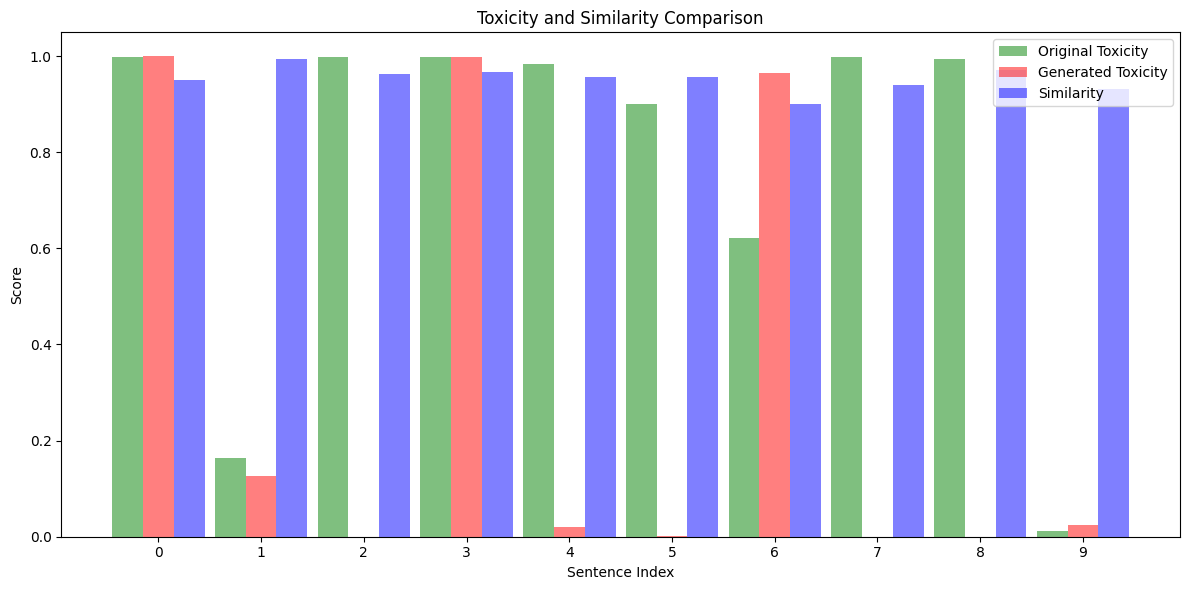

In [15]:
import matplotlib.pyplot as plt
# Create a list of indices for the sentences
indices = np.arange(10)

# Set the width of the bars
bar_width = 0.3

# Plot the data
plt.figure(figsize=(12, 6))

# Original Toxicity Level
plt.bar(indices, df_generated_paraphrases.iloc[:10]['Original Toxicity Score'], width=bar_width, color='g', align='center', label='Original Toxicity', alpha=0.5)

# Generated Toxicity Level
plt.bar(indices + bar_width, df_generated_paraphrases.iloc[:10]['Generated Toxicity Score'], width=bar_width, color='r', align='center', label='Generated Toxicity', alpha=0.5)

# Similarity
plt.bar(indices + 2*bar_width, df_generated_paraphrases.iloc[:10]['Similarity (meaning)'], width=bar_width, color='b', align='center', label='Similarity', alpha=0.5)

# Add labels
plt.xlabel('Sentence Index')
plt.ylabel('Score')
plt.title('Toxicity and Similarity Comparison')
plt.xticks(indices + bar_width, indices)  # Set x-axis labels to be sentence indices
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

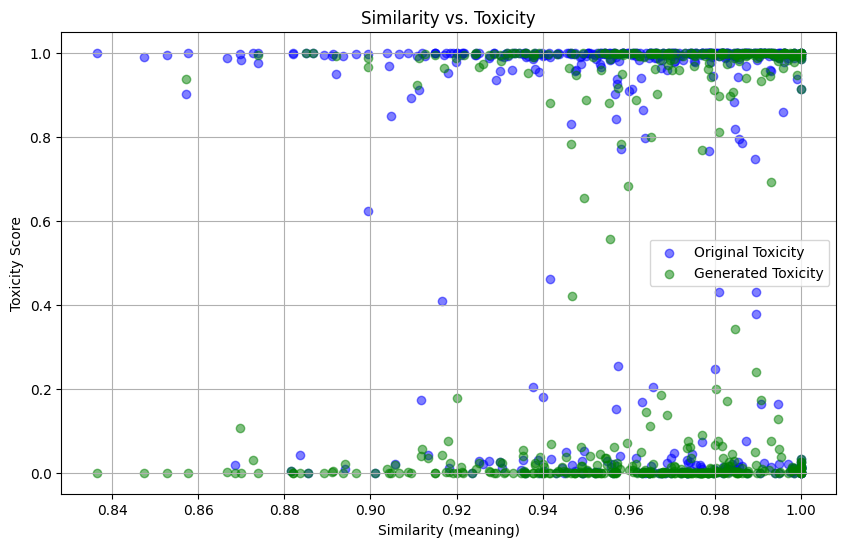

In [16]:
# Scatter plot comparing similarity and toxicity levels
plt.figure(figsize=(10, 6))

plt.scatter(df_generated_paraphrases['Similarity (meaning)'], df_generated_paraphrases['Original Toxicity Score'], color='blue', label='Original Toxicity', alpha=0.5)
plt.scatter(df_generated_paraphrases['Similarity (meaning)'], df_generated_paraphrases['Generated Toxicity Score'], color='green', label='Generated Toxicity', alpha=0.5)

plt.xlabel('Similarity (meaning)')
plt.ylabel('Toxicity Score')
plt.title('Similarity vs. Toxicity')
plt.legend()
plt.grid(True)

plt.show()

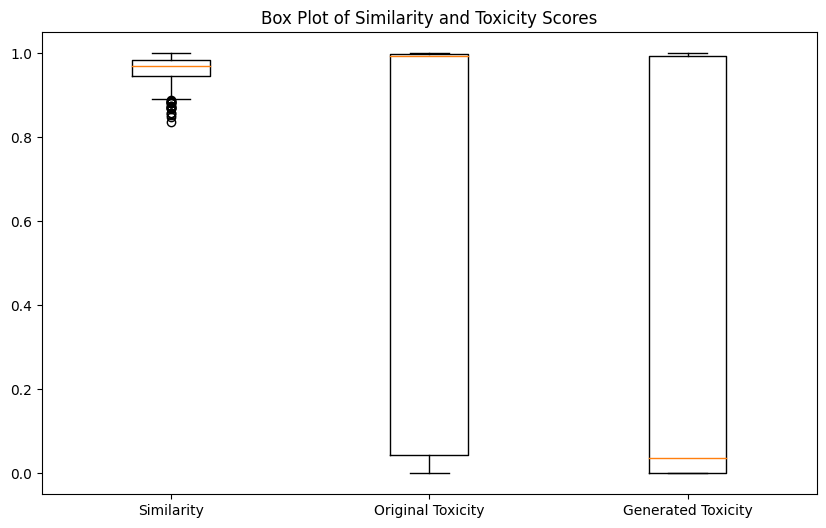

In [17]:
plt.figure(figsize=(10, 6))

plt.boxplot([df_generated_paraphrases['Similarity (meaning)'], df_generated_paraphrases['Original Toxicity Score'], df_generated_paraphrases['Generated Toxicity Score']], labels=['Similarity', 'Original Toxicity', 'Generated Toxicity'])
plt.title('Box Plot of Similarity and Toxicity Scores')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


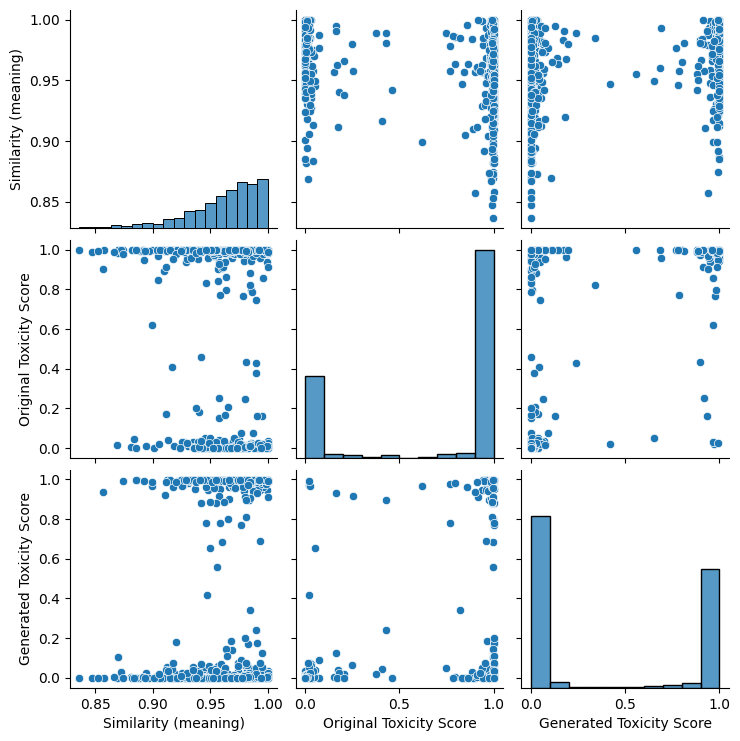

In [18]:
import seaborn as sns

sns.pairplot(df_generated_paraphrases[['Similarity (meaning)', 'Original Toxicity Score', 'Generated Toxicity Score']])
plt.show()